In [27]:
import pandas as pd
import numpy as np
import os
import keras
import itertools
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.core import Dense, Flatten
import sklearn
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import confusion_matrix

In [28]:
# path to data you want to train on
train_path = 'train'
test_path = 'test'

In [29]:
# pre-process the training data
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path, target_size=(224,224),batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path, target_size=(224,224),batch_size=32,shuffle=False)

Found 197 images belonging to 3 classes.
Found 3 images belonging to 3 classes.


In [30]:
# get the MobileNet model - single pre-trained model with weights from training on ImageNet images
mobile = keras.applications.mobilenet.MobileNet()
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [31]:
# modify the model - 3 output nodes for cats, dogs, horses (per training data)
x = mobile.layers[-6].output
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [32]:
#
for layer in model.layers[:-5]:
    layer.trainable = False

In [33]:
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
model.compile(Adam(lr=.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
model.fit_generator(train_batches, steps_per_epoch=4, epochs=30, verbose=2)

Epoch 1/30
 - 16s - loss: 1.4378 - acc: 0.3047
Epoch 2/30
 - 13s - loss: 0.8319 - acc: 0.6444
Epoch 3/30
 - 17s - loss: 0.3455 - acc: 0.9141
Epoch 4/30
 - 16s - loss: 0.2165 - acc: 0.9169
Epoch 5/30
 - 17s - loss: 0.1649 - acc: 0.9609
Epoch 6/30
 - 16s - loss: 0.1555 - acc: 0.9160
Epoch 7/30
 - 11s - loss: 0.0931 - acc: 1.0000
Epoch 8/30
 - 16s - loss: 0.0628 - acc: 1.0000
Epoch 9/30
 - 15s - loss: 0.1452 - acc: 0.9580
Epoch 10/30
 - 22s - loss: 0.0584 - acc: 1.0000
Epoch 11/30
 - 13s - loss: 0.0537 - acc: 1.0000
Epoch 12/30
 - 18s - loss: 0.0339 - acc: 1.0000
Epoch 13/30
 - 13s - loss: 0.0289 - acc: 1.0000
Epoch 14/30
 - 12s - loss: 0.0435 - acc: 1.0000
Epoch 15/30
 - 16s - loss: 0.0244 - acc: 1.0000
Epoch 16/30
 - 15s - loss: 0.0516 - acc: 1.0000
Epoch 17/30
 - 17s - loss: 0.0249 - acc: 1.0000
Epoch 18/30
 - 12s - loss: 0.1537 - acc: 0.9160
Epoch 19/30
 - 18s - loss: 0.0156 - acc: 1.0000
Epoch 20/30
 - 15s - loss: 0.0522 - acc: 1.0000
Epoch 21/30
 - 14s - loss: 0.0167 - acc: 1.0000
E

In [35]:
test_labels = test_batches.classes

In [36]:
test_labels

array([0, 1, 2], dtype=int32)

In [37]:
test_batches.class_indices

{'cat': 0, 'dog': 1, 'horse': 2}

In [38]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
predictions

array([[9.9987841e-01, 1.0867497e-04, 1.2932200e-05],
       [2.5901210e-03, 9.8128903e-01, 1.6120879e-02],
       [1.2451676e-03, 9.2395832e-04, 9.9783081e-01]], dtype=float32)

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    thresh = cm.max() / 2.
    
    print(thresh)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True_label')
    plt.xlabel('Predicted_label')

In [40]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [41]:
test_batches.class_indices

{'cat': 0, 'dog': 1, 'horse': 2}

In [42]:
cm

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

Confusion matrix, without normalization
[[1 0 0]
 [0 1 0]
 [0 0 1]]
0.5


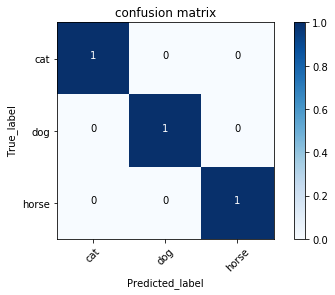

In [44]:
cm_plot_labels = ['cat', 'dog', 'horse']
plot_confusion_matrix(cm, cm_plot_labels, title='confusion matrix')

In [14]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
6/6 [==============================] - 83s 14s/step - loss: 1.3030 - acc: 0.6042
Epoch 2/5
6/6 [==============================] - 63s 11s/step - loss: 0.2062 - acc: 0.9066
Epoch 3/5
6/6 [==============================] - 61s 10s/step - loss: 0.0918 - acc: 0.9787
Epoch 4/5
6/6 [==============================] - 60s 10s/step - loss: 0.3154 - acc: 0.9386
Epoch 5/5
6/6 [==============================] - 67s 11s/step - loss: 0.1190 - acc: 0.9520


In [8]:
# predict model
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
test_generator=test_datagen.flow_from_directory(‘./test_data/’, target_size=(224,224),color_mode=’rgb’,batch_size=32,class_mode=’categorical’, shuffle=True)

SyntaxError: invalid syntax (<ipython-input-4-8a59e1b739b7>, line 1)

In [ ]:
# model.predict(test_generator)